Unique Camera Callibration For Camera-Lidar Sensor Fusion

Goal

To unwarp the picture so that the camera matches up with the lidar points

![title](general_images/image_lidar_overlay.png)

![title](general_images/lidar_points.png)

Problem

Standard methods of image calibration (for example https://wiki.ros.org/image_proc) do not work well with our camera (https://reolink.com/us/product/reolink-duo-poe/)

![title](general_images/camera.jpg)

Import necessary libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator

Load in calibration images

In [119]:
offset = 175
middle_image = cv2.imread('calibration_images/middle_image.png')
width = middle_image.shape[1]
middle_image = middle_image[:, offset:-300]
left_image = cv2.imread('calibration_images/left_image.png')[:, :width//2]
right_image = cv2.imread('calibration_images/right_image.png')[:, width//2:]

Defines function to display image

In [114]:
def display(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image_rgb)

Defines function to automatically detect as many corners as possible

In [18]:
def getCorners(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    corners, quality = cv2.goodFeaturesToTrackWithQuality(
        gray_image, maxCorners=200, qualityLevel=0.10, minDistance=7, mask=None)
    
    return corners

Defines function to display corners

In [32]:
def displayCorners(img, corners, display_numbers=True):
    _img = img.copy()
    red = (0, 0, 255)
    for i in range(len(corners)):
        point = corners[i, 0].astype(int)
        cv2.circle(_img, point, 3, red, -1)
        if display_numbers:
            cv2.putText(_img, str(i), point - [0, 2], 0, 0.5, red)
    disp(_img)

Define Radial Basis Function

(for an in depth explanation on how RBFs work see: https://www.simplilearn.com/tutorials/machine-learning-tutorial/what-are-radial-basis-functions-neural-networks)

In [10]:
def getRBF(actual_corners, ideal_corners, additional_points):
    print(ideal_corners.shape)
    print(actual_corners.shape)

    filter = actual_corners[:,0,0] != -1.

    ideal_pair = np.squeeze(ideal_corners, axis=1)[filter]
    print(ideal_pair.dtype, ideal_pair.shape)

    actual_x = actual_corners[filter][:,0,0]
    print(actual_x.dtype, actual_x.shape)

    actual_y = actual_corners[filter][:,0,1]

    if additional_points is not None:
        actual_additional_points = additional_points[0]
        ideal_additional_points = additional_points[1]

        ideal_pair = np.concatenate((ideal_pair, ideal_additional_points))
        print("ideal", ideal_pair[-2:])

        actual_x = np.concatenate((actual_x, actual_additional_points[:,0]))
        print("actual x", actual_x[-2:])

        actual_y = np.concatenate((actual_y, actual_additional_points[:,1]))
        print("actual y", actual_y[-2:])

    rbf_x = RBFInterpolator(ideal_pair, actual_x)
    rbf_y = RBFInterpolator(ideal_pair, actual_y)

    return rbf_x, rbf_y, filter

Map image according coeficients

In [11]:
def undistort(img, new_shape, actual_corners, ideal_corners, additional_points=None):
    old_shape = img.shape[:2]
    fun_x, fun_y, filter = getRBF(actual_corners, ideal_corners, additional_points)

    x_off = -30*scale #old_shape[0] - new_shape[0]
    y_off = 0 #old_shape[1] - new_shape[1]

    map_x = np.zeros(new_shape, dtype=np.float32)
    map_y = np.zeros(new_shape, dtype=np.float32)
    for i in range(map_x.shape[0]):
        for j in range(map_x.shape[1]):
            map_x[i,j] = fun_x(np.array([[j+x_off, i+y_off]]))
            map_y[i,j] = fun_y(np.array([[j+x_off, i+y_off]]))

    return map_x, map_y, filter

Display left camera picture of calibration board

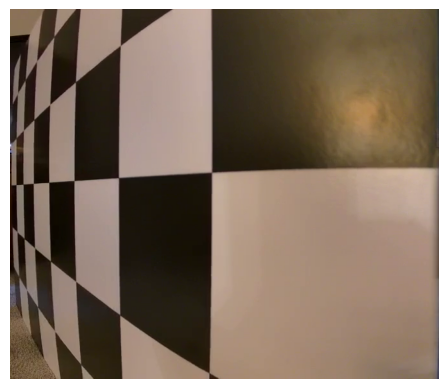

In [13]:
display(left_image)

Find potential corners

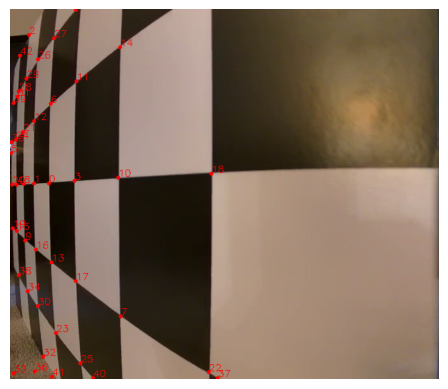

In [68]:
corners = getCorners(left_image)
displayCorners(left_image, corners)

Manually remove incorrect corners

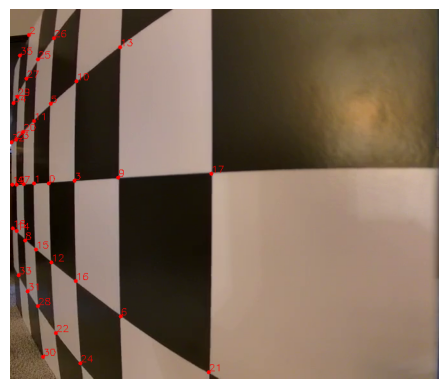

In [58]:
def remove_corners(corners, indexes_to_remove):
    mask = [True] * len(corners)
    for i in indexes_to_remove:
        mask[i] = False
    real_corners = corners[mask]
    return real_corners

removed_corners = remove_corners(corners, [37, 33, 36, 40, 5, 28, 41, 43])
displayCorners(left_image, removed_corners)

Lineup the indexes of the corners

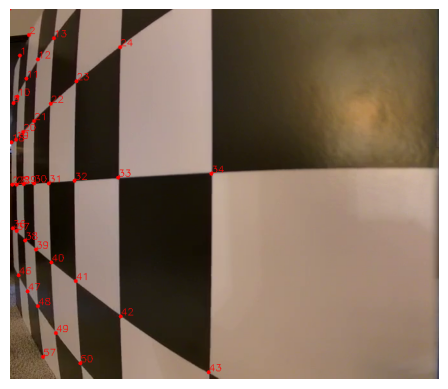

In [102]:
def relabel_corner_indexes(corners, relabling, grid_size):
    assert (sorted(list(relabling.keys())) == list(range(len(corners)))),\
        "map does not map all detected corner points"
    
    real_corners = np.zeros((grid_size[0] * grid_size[1], 1, 2)) - 1
    for i in range(len(corners)):
        real_corners[relabling[i]] = corners[i]
    return real_corners

grid_size = (7, 9)
relabling = {35:1, 2:2,
             34:9, 29:10, 27:11, 25:12, 26:13,
             32:18, 23:19, 20:20, 11:21, 5:22, 10:23, 13:24,
             19:27, 4:28, 7:29, 1:30, 0:31, 3:32, 9:33, 17:34,
             18:36, 14:37, 8:38, 15:39, 12:40, 16:41, 6:42, 21:43,
             33:46, 31:47, 28:48, 22:49, 24:50,
             30:57}

relabeled_corners = relabel_corner_indexes(removed_corners, relabling, grid_size)
displayCorners(left_image, relabeled_corners)

Manually add aditional corners

(576, 668, 3)


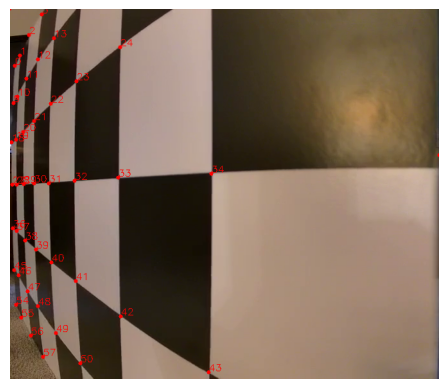

In [104]:
def add_new_corners(corners, new_corners):
    for i, point in new_corners:
        corners[i] = point
    return corners

print(left_image.shape)
new_corners = [[0, (7, 88)], [3, (49,8)],
               [35, (668, 227)],
               [45, (6, 406)],
               [54, (9, 460)], [55, (17, 480)], [56, (32, 508)]]

actual_corners = add_new_corners(relabeled_corners, new_corners)
displayCorners(left_image, actual_corners)

Create ideal corner points

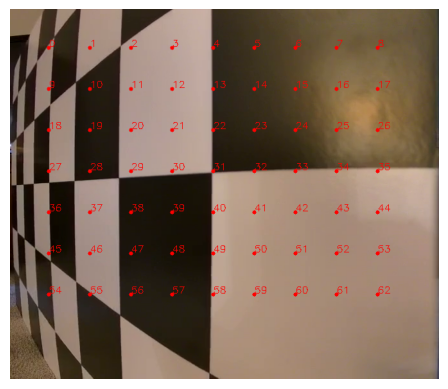

In [89]:
def create_ideal_corners(start_point, block_length, grid_size):
    ideal_corners = np.zeros((grid_size[0] * grid_size[1], 1, 2))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            ideal_corners[grid_size[1] * i + j, 0] = start_point
            start_point[0] += block_length
        start_point[1] += block_length
        start_point[0] -= block_length * grid_size[1]
    return ideal_corners

ideal_corners = create_ideal_corners([60, 60], 64, grid_size)
displayCorners(left_image, ideal_corners)

Display right camera picture of calibration board

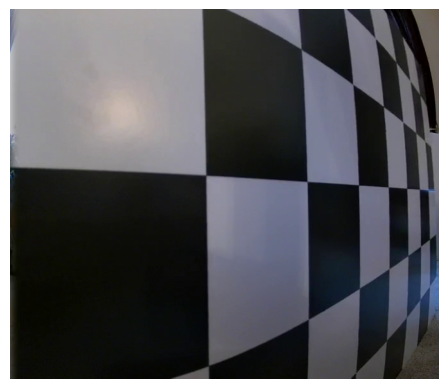

In [90]:
display(right_image)

Find potential corners

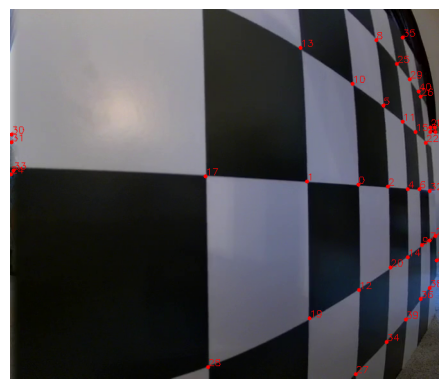

In [97]:
corners = getCorners(right_image)
displayCorners(right_image, corners)

Manually keep correct corners

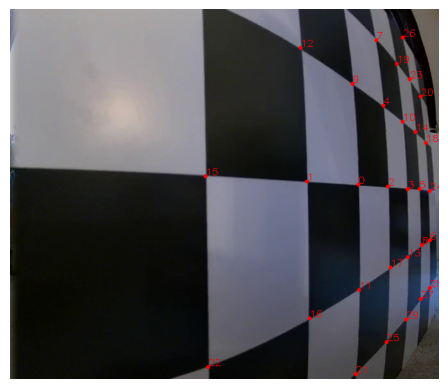

In [105]:
def keep_corners(corners, indexes_to_keep):
    mask = [False] * len(corners)
    for i in indexes_to_keep:
        mask[i] = True
    real_corners = corners[mask]
    return real_corners

indexes_to_keep = [35, 8, 25, 29, 26, 13, 10, 5, 11, 15, 22, 17, 1, 0, 2, 4, 6, 32,
                   28, 19, 12, 20, 14, 9, 7, 27, 34, 39, 36, 38]
kept_corners = keep_corners(corners, indexes_to_keep)
displayCorners(right_image, kept_corners)

Lineup the indexes of the corners

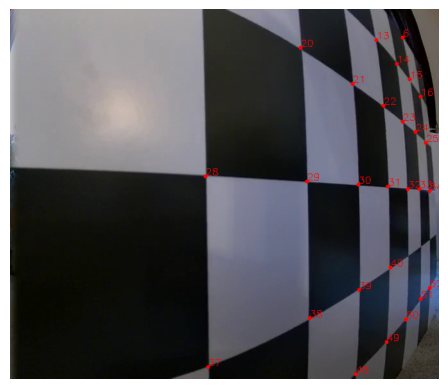

In [106]:
grid_size = (7, 9)
relabling = {26:6,
             7:13, 19:14, 23:15, 20:16,
             12:20, 9:21, 4:22, 10:23, 14:24, 18:25,
             15:28, 1:29, 0:30, 2:31, 3:32, 5:33, 24:34,
             22:37, 16:38, 11:39, 17:40, 13:40, 8:40, 6:40,
             21:48, 25:49, 29:50, 27:51, 28:52}

relabeled_corners = relabel_corner_indexes(kept_corners, relabling, grid_size)
displayCorners(right_image, relabeled_corners)

Add aditional corners

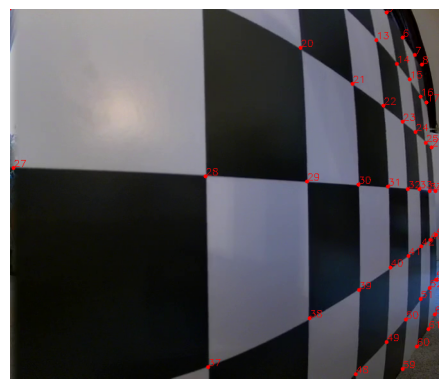

In [107]:
new_corners = [[5, (586, 5)], [7, (630, 71)], [8, (641, 86)],
               [17, (648, 145)],
               [26, (656, 215)],
               [27, (5, 247)], [35, (662, 283)],
               [41, (620, 384)], [42, (640, 369)], [43, (654, 359)], [44, (663, 351)],
               [53, (663, 421)],
               [59, (611, 560)], [60, (633, 525)], [61, (651, 498)], [62, (661, 475)]]

actual_corners = add_new_corners(relabeled_corners, new_corners)
displayCorners(right_image, actual_corners)

Create ideal corner points

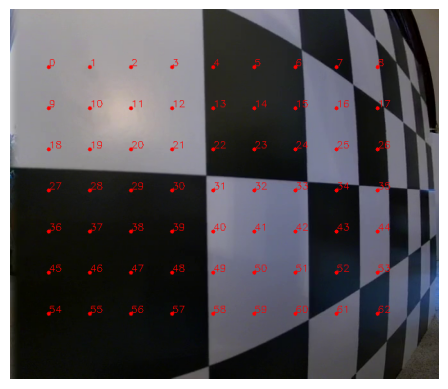

In [110]:
ideal_corners = create_ideal_corners([60, 90], 64, grid_size)
displayCorners(right_image, ideal_corners)

Display middle camera picture of calibration board

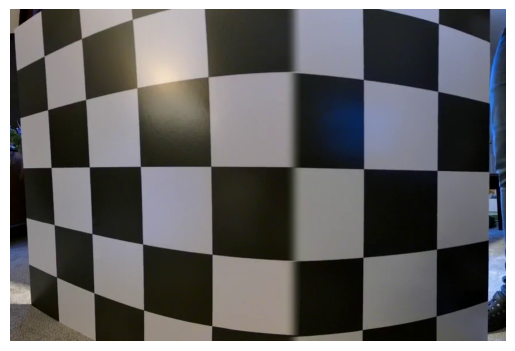

In [113]:
display(middle_image)

Find potential corners

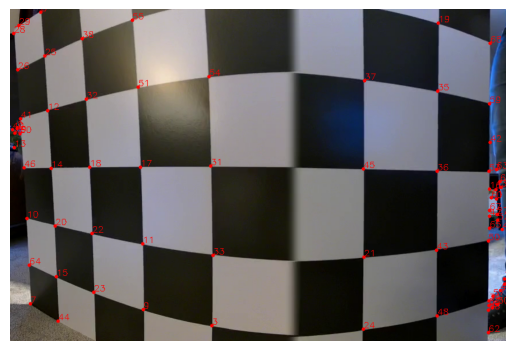

In [115]:
corners = getCorners(middle_image)
displayCorners(middle_image, corners)

Manually keep correct corners

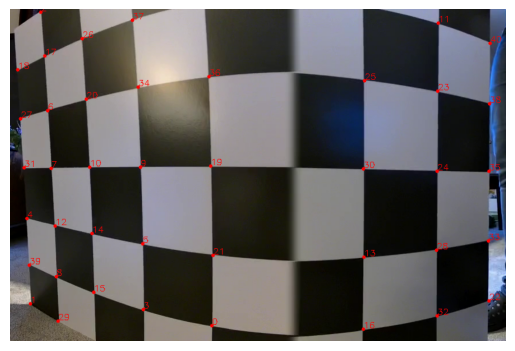

In [116]:
indexes_to_keep = [8, 26, 25, 38, 55, 19, 68, 41, 12, 32, 51, 54, 37, 35, 59, 46, 14, 18,
                   17, 31, 45, 36, 53, 10, 20, 22, 11, 33, 21, 43, 50, 64, 15, 23, 9, 3,
                   24, 48, 34, 7, 44]
kept_corners = keep_corners(corners, indexes_to_keep)
displayCorners(middle_image, kept_corners)

Lineup the indexes of the corners

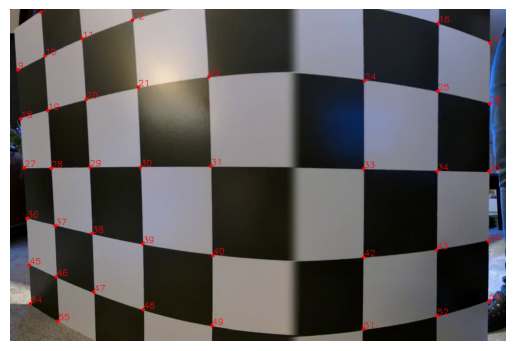

In [117]:
grid_size = (7, 9)
relabling = {2:1,
             18:9, 17:10, 26:11, 37:12, 11:16, 40:17,
             27:18, 6:19, 20:20, 34:21, 36:22, 25:24, 23:25, 38:26,
             31:27, 7:28, 10:29, 9:30, 19:31, 30:33, 24:34, 35:35,
             4:36, 12:37, 14:38, 5:39, 21:40, 13:42, 28:43, 33:44,
             39:45, 8:46, 15:47, 3:48, 0:49, 16:51, 32:52, 22:53,
             1:54, 29:55}

relabeled_corners = relabel_corner_indexes(kept_corners, relabling, grid_size)
displayCorners(middle_image, relabeled_corners)

Add additional corners

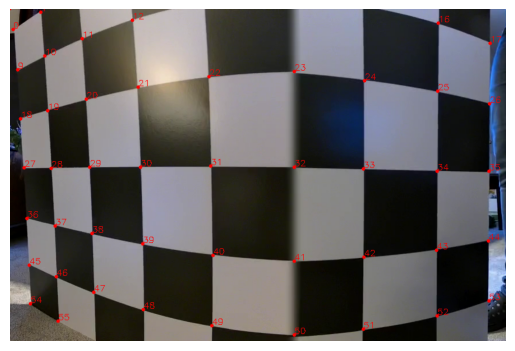

In [120]:
new_corners = [[0, (180 - offset, 35)],
               [23, (668 - offset, 108)],
               [32, (668 - offset, 274)],
               [41, (668 - offset, 437)],
               [50, (668 - offset, 565)]]

actual_corners = add_new_corners(relabeled_corners, new_corners)
displayCorners(middle_image, actual_corners)

Create ideal corner points

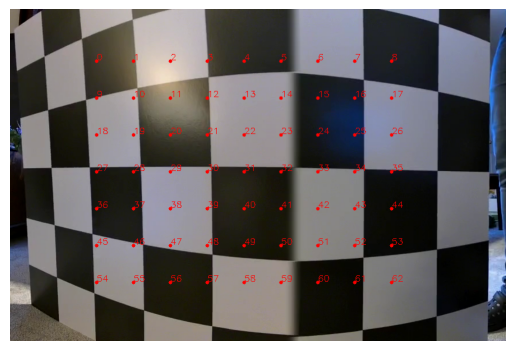

In [121]:
ideal_corners = create_ideal_corners([150, 90], 64, grid_size)
displayCorners(middle_image, ideal_corners)

Define Radial Basis Function

(for an in depth explanation on how RBFs work see: https://www.simplilearn.com/tutorials/machine-learning-tutorial/what-are-radial-basis-functions-neural-networks)

In [12]:
def make_rbf(actual_corners):
    print(ideal_corners.shape)
    print(actual_corners.shape)

    filter = actual_corners[:,0,0] != -1.

    pair = np.squeeze(ideal_corners, axis=1)[filter]
    print(pair.shape)

    rbf_x = RBFInterpolator(pair, actual_corners[filter][:,0,0])
    rbf_y = RBFInterpolator(pair, actual_corners[filter][:,0,1])

    return rbf_x, rbf_y, filter

In [13]:
rbf_x, rbf_y, filter = make_rbf(actual_corners)

(63, 1, 2)
(63, 1, 2)
(43, 2)


Map image according coeficients

In [38]:
def undistort(new_shape):
    old_shape = limg.shape[:2]
    fun_x, fun_y = rbf_x, rbf_y

    x_off = old_shape[0] - new_shape[0]
    y_off = old_shape[1] - new_shape[1]

    map_x = np.zeros(new_shape, dtype=np.float32)
    map_y = np.zeros(new_shape, dtype=np.float32)
    for i in range(map_x.shape[0]):
        for j in range(map_x.shape[1]):
            map_x[i,j] = fun_x(np.array([[j+x_off, i+y_off]]))
            map_y[i,j] = fun_y(np.array([[j+x_off, i+y_off]]))

    return cv2.remap(limg, map_x, map_y, cv2.INTER_LANCZOS4), map_x, map_y

In [39]:
per, map_x, map_y = undistort(limg.shape[:2])

In [59]:
map = np.stack((map_x, map_y), axis=2)
map1, map2 = cv2.convertMaps(map_x, map_y, cv2.CV_16SC2)
print(map1[0,20])

np.save('./calibration_np/left_calibration.npy', map)

[-11  22]


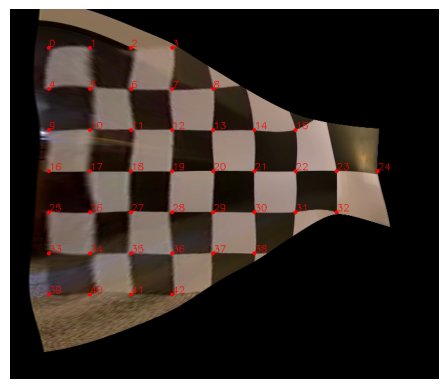

In [60]:
map = np.load('./calibration_np/left_calibration.npy')

per = cv2.remap(limg, map, None, cv2.INTER_CUBIC)
disp(displayCorners(per, ideal_corners[filter]))

(63, 1, 2)
(63, 1, 2)
(43, 2)


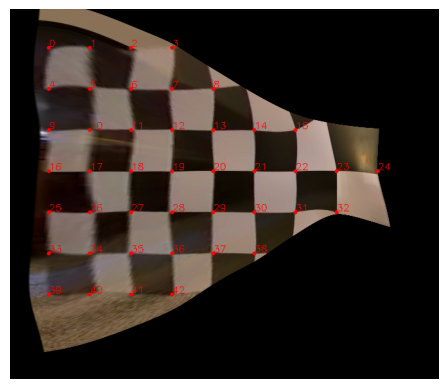

In [37]:
factual_corners = actual_corners.copy()

i=0; factual_corners[i] = actual_corners[i] + [-1, 2]
i=1; factual_corners[i] = actual_corners[i] + [1, -1]

rbf_x, rbf_y, filter = make_rbf(factual_corners)
per, map_x, map_y = undistort(limg.shape[:2])
disp(displayCorners(per, ideal_corners[filter]))

Conclusion

Looks wonky but good enough for minimal viable product

What Still Needs to Get Done For MVP

* Get right side calibration
* Combine callibrations
* Save to npy file

Further Improvents

* Sub-pixel corner detections (https://docs.opencv.org/3.4/dd/d92/tutorial_corner_subpixels.html)
* Iteratively calibrate with lidar (https://arxiv.org/pdf/2303.09825)